In [1]:
import os
import math
from os import path
from datetime import datetime, timedelta, date
import pytz

# https://igraph.discourse.group/t/igraph-for-python3-plotting-using-pycairo-on-mac-oscatalina-10-15-4/162
# Install with:
# conda install -c conda-forge python-igraph
from igraph import *

import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [14]:
# Various datasets to visualize

option = 7
time0 = time1 = ''

if option == 1:
    title = "SABETI RETREAT 2020 OO SIMULATION"
    base_folder = "./simulations/retreat2020"
    sim_id = 29
    sim_tz = "US/Eastern"
if option == 2:
    title = "CMU TEST OO SIMULATION"
    base_folder = "./simulations/cmutest"
    sim_id = 32
    sim_tz = "US/Mountain"
if option == 3:
    title = "CMU OO SIMULATION"
    base_folder = "./simulations/cmu"
    sim_id = 34
    sim_tz = "US/Mountain"
if option == 4:
    title = "FGCU OO SIMULATION"
    base_folder = "./simulations/fgcu"
    sim_id = 33
    sim_tz = "US/Eastern"
if option == 5:
    title = "CSW1 OO SIMULATION"
    base_folder = "./simulations/csw1"
    sim_id = 36
    sim_tz = "US/Eastern" 
if option == 6:
    title = "CSW2 OO SIMULATION"
    base_folder = "./simulations/csw2"
    sim_id = 37
    sim_tz = "US/Eastern" 
if option == 7:
    title = "BYU21 OO SIMULATION"
    base_folder = "./simulations/byu21"
    sim_id = 39
    sim_tz = "US/Mountain"
    time0 = 'Feb 19 2021 12:00AM'
    time1 = 'Feb 19 2021 11:59PM'    

In [3]:
# Some config

# Coded outcomes:
# 0 = no infection
# 1 = index case
# 2 = transmission
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
color_dict = {0: clr.to_hex("skyblue"), 1: clr.to_hex("crimson"), 2: clr.to_hex("orange")}

data_folder = path.join(base_folder, "data")
output_folder = path.join(base_folder, "output", "epi_plots")
if not path.exists(output_folder):
    os.makedirs(output_folder)
    
frame_format = "png"
create_movie = True
movie_fps = 2

# Time delta for plots in seconds
min_step = 30
time_delta = 60 * min_step

label_spacing = 2

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)

if time0 and time1:
    obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))
else:
    obs_date0 = None
    obs_date1 = None

In [4]:
# Some utility functions

def get_transmissions(events):
    infections = events[(events["type"] == "infection")]
    
    tlist = []
    infected = infections.user_id.values
    peers = infections.inf.values    
    for id1, peer0 in zip(infected, peers):
        n1 = user_index[id1]
        
        if "PEER" in peer0:
            p2p0 = peer0[peer0.index("[") + 1:peer0.index(":")]
            n0 = user_index[p2pToId[p2p0]]
            tlist += [(n0, n1)]
            
    return tlist    

def get_outcomes(events, outcomes0 = None):
    inf = events[events["type"] == "infection"]
    infMap = pd.Series(inf.inf.values, index=inf.user_id).to_dict()
    
    if outcomes0 == None:
         outcomes = [0] * len(users)
    else:            
        outcomes = outcomes0
        
    for kid in infMap:
        src = infMap[kid]
        idx = user_index[kid]
        if "CASE0" in src:
            outcomes[idx] = 1
        if "PEER" in src:
            outcomes[idx] = 2
    
    return outcomes

def get_network(transmissions, outcomes):
    nvert = len(user_index)
    
    g = Graph(directed=True)
    g.add_vertices(nvert)
    g.add_edges(transmissions)

    if outcomes:
        g.vs["outcome"] = outcomes
        g.vs["color"] = [color_dict[out] for out in g.vs["outcome"]]
    
    return g

In [5]:
# Load participants and histories

all_users = pd.read_csv(path.join(data_folder, "participants.csv")) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"))

users = all_users[all_users["sim_id"] == sim_id]
events = all_events[all_events["sim_id"] == sim_id]

events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()
        
user_index = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    idx += 1

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

432
432
386
432


In [6]:
min_time = min(events['time'])
max_time = max(events['time'])

first_date = datetime.fromtimestamp(min_time, tz=timezone)
last_date = datetime.fromtimestamp(max_time, tz=timezone)

print("First event:", first_date)
print("Last event :", last_date)
print(first_date.tzinfo)

First event: 2021-02-19 08:18:12-07:00
Last event : 2021-02-20 06:28:48-07:00
US/Mountain


BYU21 OO SIMULATION
Report 2021-02-19 00:00:00 to 2021-02-19 23:59:00

Summary statistics:
Final number of susceptibles: 411
Total number of cases: 21
Total number of deaths: 5
Total number of recoveries: 3
Total number of escapes: 38
Total number of contacts: 3787

Epidemiological plots:


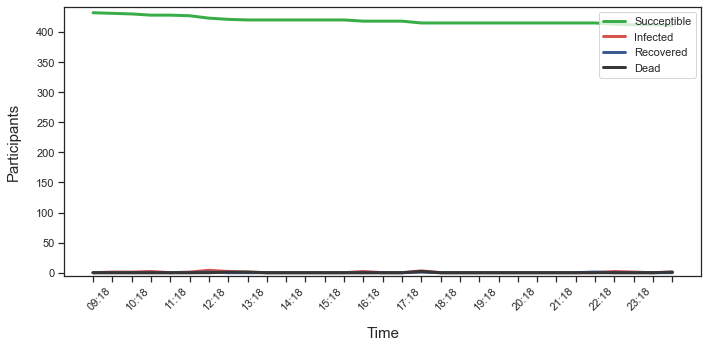

<Figure size 432x288 with 0 Axes>

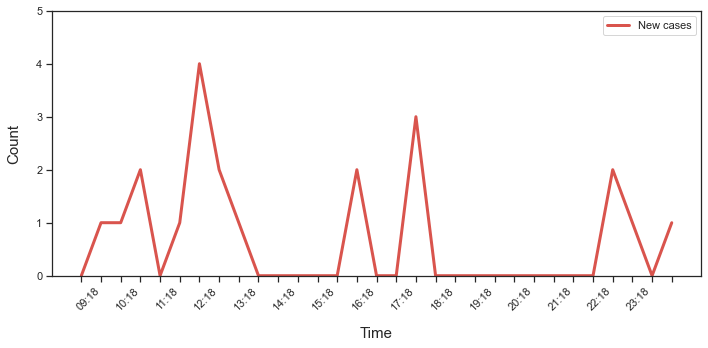

<Figure size 432x288 with 0 Axes>

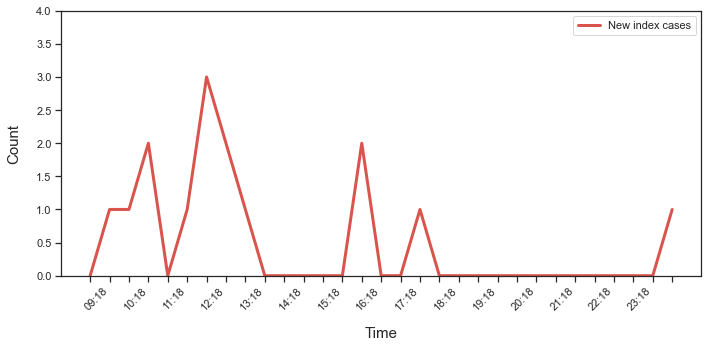

<Figure size 432x288 with 0 Axes>

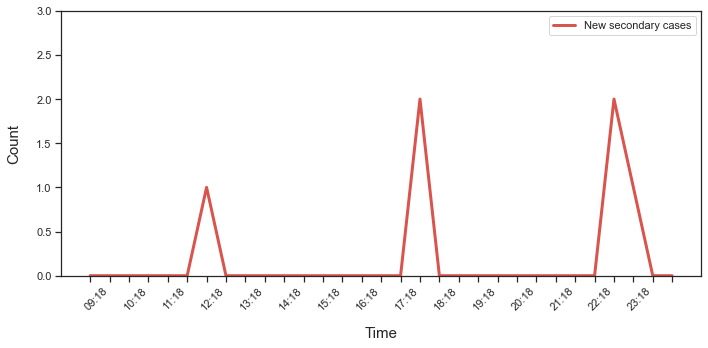

<Figure size 432x288 with 0 Axes>

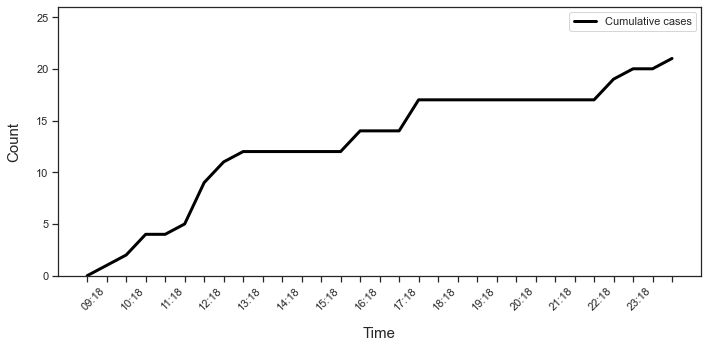

<Figure size 432x288 with 0 Axes>

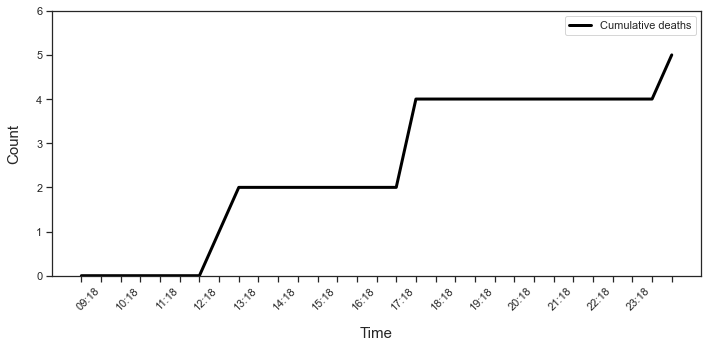

<Figure size 432x288 with 0 Axes>

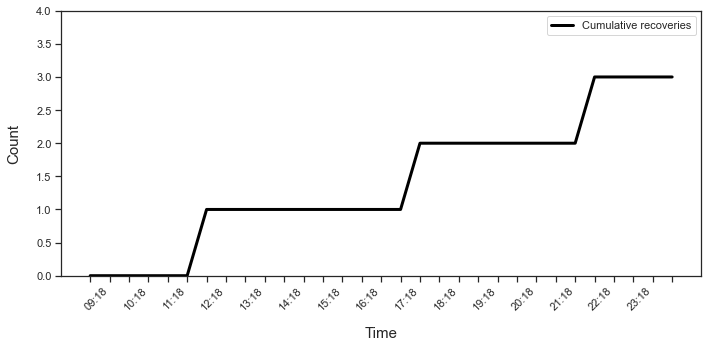

<Figure size 432x288 with 0 Axes>

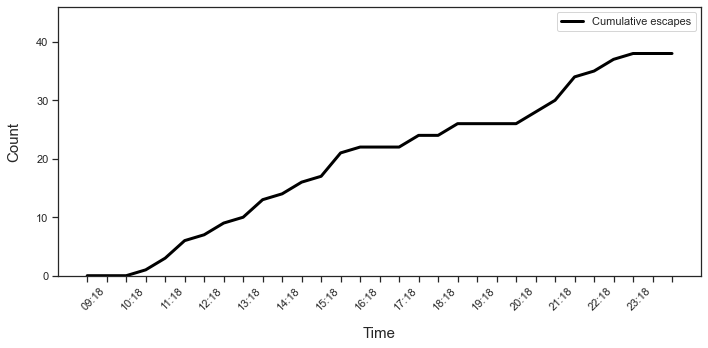

<Figure size 432x288 with 0 Axes>

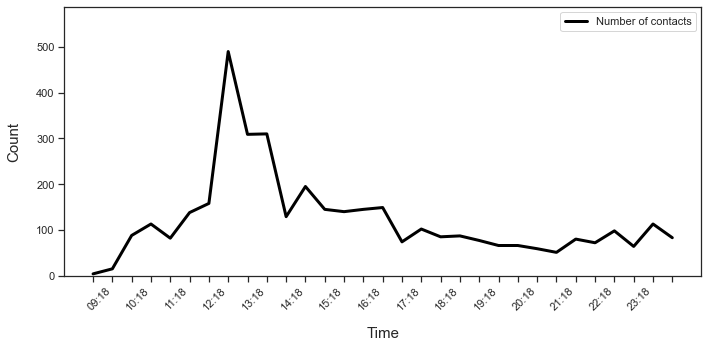

In [20]:
sns.set()
sns.set_style("ticks")

S = []
I = []
I0 = []
I2 = []
R = []
C = []
CD = []
CR = []
CE = []
NC = []
NRec = []
NDead = []
NEsc = []
index = []
tlabels = []
tlabels_all = []

ntot = len(users)
ncum = 0
ndcum = 0
nrcum = 0
necum = 0    
t = min_time
idx = 0
img_array = []
frame = 0
while t <= max_time:
    t0 = t
    t += time_delta
    td = datetime.fromtimestamp(t, tz=timezone)
    
    nrem = 0
    ninf = 0
    nindex = 0
    ntrans = 0  
    ncont = 0
    
    condition = (t0 < events['time']) & (events['time'] <= t)    
    tevents = events[condition]        
    infections = tevents[tevents['type'] == "infection"]
    outcomes = tevents[tevents['type'] == "outcome"]
    
    recovered = outcomes[outcomes["out"] == "RECOVERED"]
    dead = outcomes[outcomes["out"] == "DEAD"]
    escaped = outcomes[outcomes["out"] == "ESCAPED"]
    
    ndead = len(dead)
    nrec = len(recovered)
    nesc = len(escaped)
    nrem = nrec + nesc + ndead

    ninf = len(infections)
    infMap = pd.Series(infections.inf.values, index=infections.id).to_dict()
    nindex = 0
    ntrans = 0    
    for kid in infMap:
        src = infMap[kid]
        if "CASE0" in src:
            nindex += 1
        if "PEER" in src:
            ntrans += 1
        
    ccondition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    cevents = events[ccondition] 
    contacts = cevents[cevents['type'] == "contact"]     
    ncont = len(contacts)

    ncum += ninf
    ndcum += ndead
    nrcum += nrec
    necum += nesc

    if not obs_date0 or not obs_date1 or (obs_date0 <= td and td <= obs_date1):
        S += [ntot - ncum]
        I += [ninf]
        I0 += [nindex]
        I2 += [ntrans]
        R += [nrem]
        NDead += [ndead]
        NRec += [nrec]
        NEsc += [nesc]
        C += [ncum]
        CD += [ndcum]
        CR += [nrcum]
        CE += [necum]
        NC += [ncont]
        frame += 1    
        index += [frame]
        if frame % label_spacing == 0:        
            tlabels += [td.strftime('%H:%M')]
        else:        
            tlabels += [""]
        tlabels_all += [td.strftime('%H:%M')]    
    else:
#         print("skipping", td)
        pass

df = pd.DataFrame({"Time": tlabels_all,                    
                   "Susceptible": S, "Infected": I, "Dead": NDead, "Recovered": NRec, "Escaped": NEsc,
                   "Total cumulative cases": C, "Total cumulative deaths": CD, "Total cumulative recoveries": CR, "Total cumulative escaped": CE,
                   "Index cases": I0, "Secondary cases": I2, "Number of contacts": NC})
df.to_excel(os.path.join(output_folder, "epi-data.xlsx"), index=False)

print(title)
if time0 and time1:
    print("Report", datetime.strptime(time0, '%b %d %Y %I:%M%p'), "to", datetime.strptime(time1, '%b %d %Y %I:%M%p'))
else:
    print("Report")

print("")
print("Summary statistics:")
print("Final number of susceptibles:", S[-1])
print("Total number of cases:", C[-1])
print("Total number of deaths:", CD[-1])
print("Total number of recoveries:", CR[-1])
print("Total number of escapes:", CE[-1])
print("Total number of contacts:", sum(NC))

print("")
print("Epidemiological plots:")

# Combined SIR curves
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([-5, ntot + 10])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(index, S, label="Succeptible", color=sns.xkcd_rgb["medium green"], lw=3)
ax.plot(index, I, label="Infected", color=sns.xkcd_rgb["pale red"], lw=3)
ax.plot(index, NRec, label="Recovered", color=sns.xkcd_rgb["denim blue"], lw=3)
ax.plot(index, NDead, label="Dead", color=sns.xkcd_rgb["dark grey"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "epi-curves.pdf"))

# New cases plot (index and secondary)
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, I, label="New cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-cases-curve.pdf"))

# Index cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I0) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, I0, label="New index cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-index_cases-curve.pdf"))

# Index cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(I2) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, I2, label="New secondary cases", color=sns.xkcd_rgb["pale red"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "new-secondary_cases-curve.pdf"))

# Cumulative cases plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(C) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, C, label="Cumulative cases", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "cumulative-cases.pdf"))

# Cumulative deaths plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(CD) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, CD, label="Cumulative deaths", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "cumulative-deaths.pdf"))

# Cumulative recoveries plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(CR) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, CR, label="Cumulative recoveries", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "cumulative-recoveries.pdf"))

# Cumulative escapes plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(CE) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, CE, label="Cumulative escapes", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "cumulative-escapes.pdf"))

# Number of contacts plot
plt.clf()
fig, ax = plt.subplots(figsize=(10,5))
plt.ylim([0, math.ceil(max(NC) * 1.2)])
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
ax.plot(index, NC, label="Number of contacts", color=sns.xkcd_rgb["black"], lw=3)
plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "number-contacts-curve.pdf"))

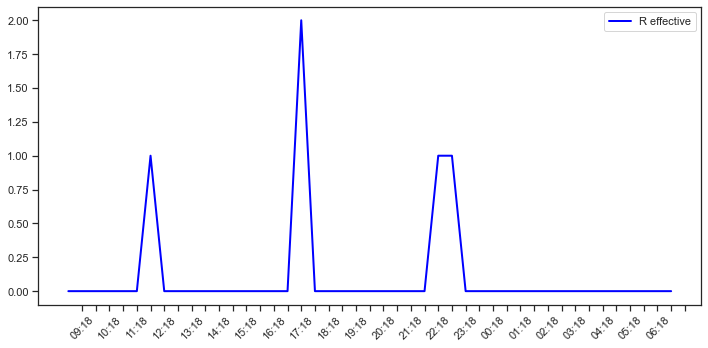

In [30]:
# R effective over time

toutcomes = None

t = min_time
frame = 0
r_mean_values = []
r_std_values = []
tlabels = []
index = []
while t <= max_time:
    t0 = t
    t += time_delta
    frame += 1    

    condition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    tevents = events[condition]
    toutcomes = get_outcomes(tevents, toutcomes)
    transmissions = get_transmissions(tevents)
    g = get_network(transmissions, toutcomes)

    td = datetime.fromtimestamp(t, tz=timezone)
    
    # Getting all nodes with at least one edge
    r_values = []    
    sel = g.vs(_degree_gt=0)

    for v in sel:
        nout = v.degree(mode=OUT)
        if nout == 0:
            # Node did not caused infections (all edges are inwards), skipping
            continue
        r_values += [nout]
    
    if r_values:
        r_mean = np.mean(r_values)
        r_std = np.std(r_values)
        r_mean_values += [r_mean]
        r_std_values += [r_std]
    else:
        r_mean_values += [0]
        r_std_values += [0]
        
    if frame % label_spacing == 0:        
        tlabels += [td.strftime('%H:%M')]
    else:        
        tlabels += [""]
    tlabels_all += [td.strftime('%H:%M')] 
    index += [frame]    

mu = np.array(r_mean_values)
sigma = np.array(r_std_values)
time = np.arange(len(sigma))
    
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("R", labelpad=15, fontsize=15)
ax.plot(time, mu, lw=2, label='R effective', color='blue')
ax.fill_between(time, mu+sigma, mu-sigma, facecolor='blue', alpha=0.5)

plt.xticks(index, tlabels, rotation=45, horizontalalignment="right")

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "r-effective.pdf"))

1.5 0.5


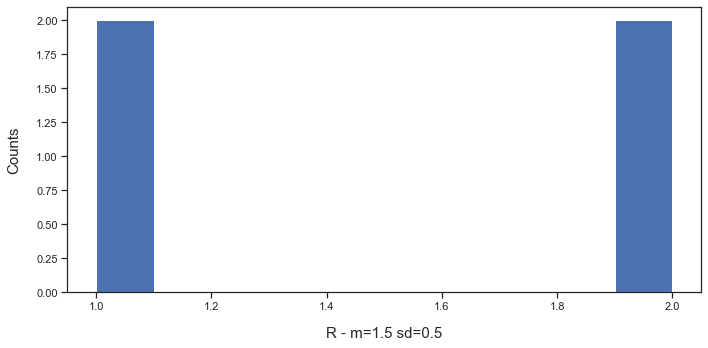

In [34]:
# Plot distribution of R averaged over the entire simulation

outcomes = get_outcomes(events)
transmissions = get_transmissions(events)
g = get_network(transmissions, outcomes)

r_values = []    
sel = g.vs(_degree_gt=0)
for v in sel:
    nout = v.degree(mode=OUT)
    if nout == 0:
        # Node did not caused infections (all edges are inwards), skipping
        continue
    r_values += [nout]

r_mean = np.mean(r_values)
r_std = np.std(r_values)
counts, bins = np.histogram(r_values)

print(r_mean, r_std)

fig, ax = plt.subplots(figsize=(10,5))
plt.ylabel("Counts", labelpad=15, fontsize=15)
plt.xlabel("R - m=" + str(round(r_mean, 2)) + " sd=" + str(round(r_std, 2)), labelpad=15, fontsize=15)
plt.hist(bins[:-1], bins, weights=counts)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "r-mean-histogram.pdf"))